In [1]:
from deepmol.pipeline import Pipeline

from deepmol.scalers import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from deepmol.models import SklearnModel
from deepmol.compound_featurization import MorganFingerprint, TwoDimensionDescriptors, LayeredFingerprint
from deepmol.standardizer import ChEMBLStandardizer
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

steps = [
         ('morgan fingerprints', MorganFingerprint(radius=2, size=1024, n_jobs=10)),
         ('random forest', SklearnModel(model=RidgeClassifier(random_state=42)))
         ]
pipeline_morgan_fp = Pipeline(steps=steps, path="morgan_fp")

pipeline_layered_fingerprints_baseline_ridge_classifier = Pipeline(steps=[('layered fingerprints', LayeredFingerprint()),
                                                                           ('ridge classifier', SklearnModel(model=RidgeClassifier(random_state=42)))])


2024-03-08 11:37:19.880558: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-08 11:37:19.924701: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-08 11:37:19.924765: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-08 11:37:19.924800: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-08 11:37:19.933347: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-08 11:37:19.934787: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
from deepmol.loaders import CSVLoader
import numpy as np


def fit_and_evaluate(pipeline):
    train = CSVLoader("train.csv",
                        labels_fields=['C00073', 'C00078', 'C00079', 'C00082', 'C00235', 'C00341', 'C00353',
                                        'C00448', 'C01789', 'C03506', 'C00047', 'C00108', 'C00187', 'C00148',
                                        'C00041', 'C00129', 'C00062', 'C01852', 'C00049', 'C00135', 'C00223',
                                        'C00509', 'C00540', 'C01477', 'C05903', 'C05904', 'C05905', 'C05908',
                                        'C09762'],
                        id_field="ids", smiles_field="smiles").create_dataset()
    valid = CSVLoader("valid.csv",
                        labels_fields=['C00073', 'C00078', 'C00079', 'C00082', 'C00235', 'C00341', 'C00353',
                                        'C00448', 'C01789', 'C03506', 'C00047', 'C00108', 'C00187', 'C00148',
                                        'C00041', 'C00129', 'C00062', 'C01852', 'C00049', 'C00135', 'C00223',
                                        'C00509', 'C00540', 'C01477', 'C05903', 'C05904', 'C05905', 'C05908',
                                        'C09762'],
                        id_field="ids", smiles_field="smiles").create_dataset()
    test = CSVLoader("test.csv",
                        labels_fields=['C00073', 'C00078', 'C00079', 'C00082', 'C00235', 'C00341', 'C00353',
                                        'C00448', 'C01789', 'C03506', 'C00047', 'C00108', 'C00187', 'C00148',
                                        'C00041', 'C00129', 'C00062', 'C01852', 'C00049', 'C00135', 'C00223',
                                        'C00509', 'C00540', 'C01477', 'C05903', 'C05904', 'C05905', 'C05908',
                                        'C09762'],
                        id_field="ids", smiles_field="smiles").create_dataset()

    train_valid = train.merge([valid])
    pipeline.fit(train_valid)
    from sklearn.metrics import f1_score, precision_score, recall_score
    from deepmol.metrics import Metric


    def macro_f1_score(y_true, y_pred):
        return f1_score(y_true, y_pred, average='macro')

    def macro_precision_score(y_true, y_pred):
        return precision_score(y_true, y_pred, average='macro')

    def macro_recall_score(y_true, y_pred):
        return recall_score(y_true, y_pred, average='macro')


    results_test = pipeline.evaluate(test, metrics=[Metric(macro_f1_score), Metric(macro_precision_score), Metric(macro_recall_score)], per_task_metrics=False)
    predictions = pipeline.predict(test)
    f1_scores = []
    recall_scores = []
    precision_scores = []
    test = pipeline.transform(test)
    for i in range(predictions.shape[1]):
        f1_score_task = f1_score(test.y[:, i], predictions[:, i])
        recall_score_task = recall_score(test.y[:, i], predictions[:, i])
        precision_score_task = precision_score(test.y[:, i], predictions[:, i])
        f1_scores.append(f1_score_task)
        recall_scores.append(recall_score_task)
        precision_scores.append(precision_score_task)
    
    results_test[0]['f1_scores_std'] = np.array(f1_scores).std()
    results_test[0]['recall_scores_std'] = np.array(recall_scores).std()
    results_test[0]['precision_scores_std'] = np.array(precision_scores).std()

    return results_test

In [3]:
import pandas as pd

pd.concat((pd.read_csv("train.csv"), pd.read_csv("valid.csv"))).to_csv("train_valid.csv", index=False)

In [4]:
from deepmol.loaders import CSVLoader

test = CSVLoader("test.csv",
                        labels_fields=['C00073', 'C00078', 'C00079', 'C00082', 'C00235', 'C00341', 'C00353',
                                        'C00448', 'C01789', 'C03506', 'C00047', 'C00108', 'C00187', 'C00148',
                                        'C00041', 'C00129', 'C00062', 'C01852', 'C00049', 'C00135', 'C00223',
                                        'C00509', 'C00540', 'C01477', 'C05903', 'C05904', 'C05905', 'C05908',
                                        'C09762'],
                        id_field="ids", smiles_field="smiles").create_dataset()

test.y.shape

2024-03-08 11:37:24,392 — INFO — Assuming multitask since y has more than one dimension. If otherwise, explicitly set the mode to 'classification' or 'regression'!


(169, 29)

In [5]:
from deepmol.pipeline import Pipeline

pipeline_285 = Pipeline.load('../sm_predictor_pipeline_tpe_sklearn/trial_285')

In [6]:
print("Morgan FP")
results_pipeline_morgan_fp = fit_and_evaluate(pipeline_morgan_fp)
print("Layered FP and Ridge Classifier")
results_pipeline_layered_fingerprints_baseline_ridge_classifier = fit_and_evaluate(pipeline_layered_fingerprints_baseline_ridge_classifier)
print("Layered FP and Ridge Classifier (optimized)")
results_pipeline_285 = fit_and_evaluate(pipeline_285)

Morgan FP
2024-03-08 11:37:24,603 — INFO — Assuming multitask since y has more than one dimension. If otherwise, explicitly set the mode to 'classification' or 'regression'!
2024-03-08 11:37:24,661 — INFO — Assuming multitask since y has more than one dimension. If otherwise, explicitly set the mode to 'classification' or 'regression'!
2024-03-08 11:37:24,694 — INFO — Assuming multitask since y has more than one dimension. If otherwise, explicitly set the mode to 'classification' or 'regression'!
2024-03-08 11:37:24,697 — ERROR — Features are not the same length/type... Recalculate features for all inputs!
Layered FP and Ridge Classifier
2024-03-08 11:37:27,880 — INFO — Assuming multitask since y has more than one dimension. If otherwise, explicitly set the mode to 'classification' or 'regression'!
2024-03-08 11:37:27,948 — INFO — Assuming multitask since y has more than one dimension. If otherwise, explicitly set the mode to 'classification' or 'regression'!
2024-03-08 11:37:27,983 — 

In [7]:
import pandas as pd

results_mgcnn = pd.read_csv("results_mgcnn.csv")
pipeline_mgcnn_results = [results_mgcnn["f1_score"].mean(), results_mgcnn["precision"].mean(), results_mgcnn["recall"].mean()]
pipeline_mgcnn_results

[0.8313670437176287, 0.8334869398455086, 0.8714253464803721]

In [8]:
color_map = {'Layered FP + Low Variance FS + Ridge Classifier': (0.00392156862745098,
  0.45098039215686275,
  0.6980392156862745),
 'Layered FP + Ridge Classifier': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 'Morgan FP + Ridge Classifier': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 'Morgan FP + MLP': (0.8352941176470589, 0.3686274509803922, 0.0),
 'MGCNN (Eguchi et al. 2019)': (0.8, 0.47058823529411764, 0.7372549019607844),
 'Morgan FP + Random Forest': (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 'Morgan FP + KNN': (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 'Descriptors + Random Forest': (0.5803921568627451, 0.5803921568627451, 0.5803921568627451) }

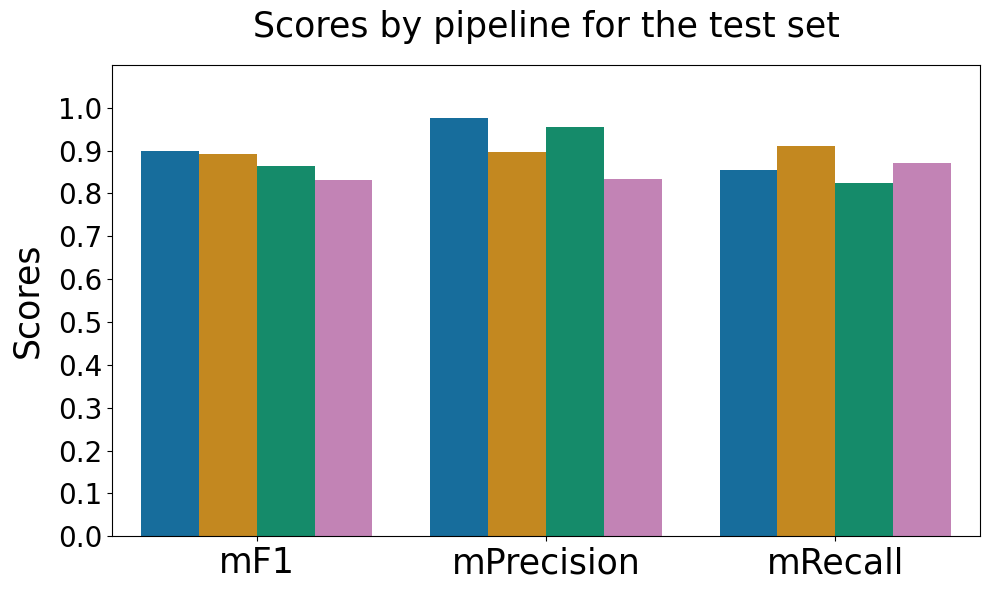

In [9]:
# plot the results of the three pipelines
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

matplotlib.rcParams['savefig.transparent'] = True

labels = ['macro_f1_score', 'macro_precision_score', 'macro_recall_score']
pipeline_285_results = [results_pipeline_285[0]['macro_f1_score'], results_pipeline_285[0]['macro_precision_score'], results_pipeline_285[0]['macro_recall_score']]
pipeline_morgan_fp_results = [results_pipeline_morgan_fp[0]['macro_f1_score'], results_pipeline_morgan_fp[0]['macro_precision_score'], results_pipeline_morgan_fp[0]['macro_recall_score']]
pipeline_layered_fingerprints_baseline_ridge_classifier_results = [results_pipeline_layered_fingerprints_baseline_ridge_classifier[0]['macro_f1_score'], results_pipeline_layered_fingerprints_baseline_ridge_classifier[0]['macro_precision_score'], results_pipeline_layered_fingerprints_baseline_ridge_classifier[0]['macro_recall_score']]

pipeline_285_std = [results_pipeline_285[0]['f1_scores_std'], results_pipeline_285[0]['precision_scores_std'], results_pipeline_285[0]['recall_scores_std']]
pipeline_morgan_fp_std = [results_pipeline_morgan_fp[0]['f1_scores_std'], results_pipeline_morgan_fp[0]['precision_scores_std'], results_pipeline_morgan_fp[0]['recall_scores_std']]
pipeline_layered_fingerprints_baseline_ridge_classifier_std = [results_pipeline_layered_fingerprints_baseline_ridge_classifier[0]['f1_scores_std'], results_pipeline_layered_fingerprints_baseline_ridge_classifier[0]['precision_scores_std'], results_pipeline_layered_fingerprints_baseline_ridge_classifier[0]['recall_scores_std']]
pipeline_mgcnn_results_std = [results_mgcnn["f1_score"].std(), results_mgcnn["precision"].std(), results_mgcnn["recall"].std()]

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sample data setup (replace with your actual data)
# Assuming you have your pipeline results as separate lists like before
# Here's how you might structure them into a DataFrame:

data = {
    "Label": labels * 4,  # Repeat 'labels' for each pipeline
    "Scores": np.concatenate([
        pipeline_285_results,
        pipeline_layered_fingerprints_baseline_ridge_classifier_results,
        pipeline_morgan_fp_results,
        pipeline_mgcnn_results,
    ]),
    "STD": np.concatenate([
        pipeline_285_std,
        pipeline_layered_fingerprints_baseline_ridge_classifier_std,
        pipeline_morgan_fp_std,
        pipeline_mgcnn_results_std,
        
    ]),
    "Pipeline": (
        ["Layered FP + Low Variance FS + Ridge Classifier"] * len(labels) +
        ["Layered FP + Ridge Classifier"] * len(labels) +
        ["Morgan FP + Ridge Classifier"] * len(labels) +
         ["MGCNN (Eguchi et al. 2019)"] * len(labels)
    )
}

df = pd.DataFrame(data)
#df.sort_values(by="Scores", ascending=False, inplace=True)  # Sort by scores for better visualization

# Plotting
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
barplot = sns.barplot(data=df, x="Label", y="Scores", hue="Pipeline", dodge=True, palette=color_map)

for i, p in enumerate(barplot.patches):
    # Calculate annotation text position
    if p.get_height() != 0:
        x = p.get_x() + p.get_width() / 2
        # Get the corresponding standard deviation from the DataFrame
        std = df.loc[i % len(df), 'STD']  # Adjust index for std
        # Add error bar for this bar using plt.errorbar
        # plt.errorbar(x, p.get_height(), yerr=std, fmt='none', capsize=5, color='black')

        # barplot.annotate(format(p.get_height(), '.3f'),  # Text to display
        #                 (p.get_x() + p.get_width() / 2., p.get_height() + 0.09),  # Position
        #                 ha='center', va='center',  # Center alignment
        #                 xytext=(0, 9),  # Distance from the top of the bar
        #                 textcoords='offset points',
        #                 size=20,  # Text size
        #                 rotation=90)  # Text rotation (90 degrees)

plt.title('Scores by pipeline for the test set', pad=20, size=25)  # Adjust title position
plt.ylabel('Scores', labelpad=10, size=25)  # Adjust y-axis label position
plt.xlabel('', labelpad=10, size=15)
# define other names for the ticks
plt.xticks([0, 1, 2], ['mF1', 'mPrecision', 'mRecall'], size=25)

legend = plt.legend(title='', bbox_to_anchor=(1.05, 1.15), loc='upper left', prop={'size': 25}, ncol=2)
fig  = legend.figure
fig.canvas.draw()
bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig("legend.png", dpi="figure", bbox_inches=bbox)
legend.remove()
        
plt.ylim(0, 1.1)  # Extend y-axis limit
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], size=20)  # Adjust y-axis ticks

plt.tight_layout()  # Adjust layout
#plt.show()
plt.savefig("scores_by_pipeline.png", dpi=400)

In [10]:
df.to_csv("scores_by_pipeline.csv", index=False)

In [11]:
pipeline_morgan_fp.steps[-1][1].model.coef_.shape

(29, 1024)

In [12]:
from sklearn.metrics import f1_score


def get_scores_by_task(pipeline):
    train = CSVLoader("train.csv",
                        labels_fields=['C00073', 'C00078', 'C00079', 'C00082', 'C00235', 'C00341', 'C00353',
                                        'C00448', 'C01789', 'C03506', 'C00047', 'C00108', 'C00187', 'C00148',
                                        'C00041', 'C00129', 'C00062', 'C01852', 'C00049', 'C00135', 'C00223',
                                        'C00509', 'C00540', 'C01477', 'C05903', 'C05904', 'C05905', 'C05908',
                                        'C09762'],
                        id_field="ids", smiles_field="smiles").create_dataset()
    valid = CSVLoader("valid.csv",
                        labels_fields=['C00073', 'C00078', 'C00079', 'C00082', 'C00235', 'C00341', 'C00353',
                                        'C00448', 'C01789', 'C03506', 'C00047', 'C00108', 'C00187', 'C00148',
                                        'C00041', 'C00129', 'C00062', 'C01852', 'C00049', 'C00135', 'C00223',
                                        'C00509', 'C00540', 'C01477', 'C05903', 'C05904', 'C05905', 'C05908',
                                        'C09762'],
                        id_field="ids", smiles_field="smiles").create_dataset()
    test = CSVLoader("test.csv",
                        labels_fields=['C00073', 'C00078', 'C00079', 'C00082', 'C00235', 'C00341', 'C00353',
                                        'C00448', 'C01789', 'C03506', 'C00047', 'C00108', 'C00187', 'C00148',
                                        'C00041', 'C00129', 'C00062', 'C01852', 'C00049', 'C00135', 'C00223',
                                        'C00509', 'C00540', 'C01477', 'C05903', 'C05904', 'C05905', 'C05908',
                                        'C09762'],
                        id_field="ids", smiles_field="smiles").create_dataset()

    train_valid = train.merge([valid])
    pipeline.fit(train_valid)
    from sklearn.metrics import f1_score, precision_score, recall_score

    predictions = pipeline.predict(test)
    test = pipeline.transform(test)

    n_tasks = predictions.shape[1]
    tasks_f1_score = []
    tasks_precision = []
    tasks_recall = []
    for task in range(n_tasks):
        tasks_f1_score.append(f1_score(test.y[:, task], predictions[:, task]))
        tasks_precision.append(precision_score(test.y[:, task], predictions[:, task]))
        tasks_recall.append(recall_score(test.y[:, task], predictions[:, task]))

    return tasks_f1_score, tasks_precision, tasks_recall

In [13]:
test = CSVLoader("test.csv",
                        labels_fields=['C00073', 'C00078', 'C00079', 'C00082', 'C00235', 'C00341', 'C00353',
                                        'C00448', 'C01789', 'C03506', 'C00047', 'C00108', 'C00187', 'C00148',
                                        'C00041', 'C00129', 'C00062', 'C01852', 'C00049', 'C00135', 'C00223',
                                        'C00509', 'C00540', 'C01477', 'C05903', 'C05904', 'C05905', 'C05908',
                                        'C09762'],
                        id_field="ids", smiles_field="smiles").create_dataset()

labels = {
    'C00341': 'Geranyl diphosphate',
    'C01789': 'Campesterol',
    'C00078': 'Tryptophan',
    'C00049': 'L-Aspartate',
    'C00183': 'L-Valine',
    'C03506': 'Indoleglycerol phosphate',
    'C00187': 'Cholesterol',
    'C00079': 'L-Phenylalanine',
    'C00047': 'L-Lysine',
    'C01852': 'Secologanin',
    'C00407': 'L-Isoleucine',
    'C00129': 'Isopentenyl diphosphate',
    'C00235': 'Dimethylallyl diphosphate',
    'C00062': 'L-Arginine',
    'C00353': 'Geranylgeranyl diphosphate',
    'C00148': 'L-Proline',
    'C00073': 'L-Methionine',
    'C00108': 'Anthranilate',
    'C00123': 'L-Leucine',
    'C00135': 'L-Histidine',
    'C00448': 'Farnesyl diphosphate',
    'C00082': 'L-Tyrosine',
    'C00041': 'L-Alanine',
    'C00540': 'Cinnamoyl-CoA',
    'C01477': 'Apigenin',
    'C05903': 'Kaempferol',
    'C05904': 'Pelargonin',
    'C05905': 'Cyanidin',
    'C05908': 'Delphinidin',
    'C00389': 'Quercetin',
    'C01514': 'Luteolin',
    'C09762': "Liquiritigenin",
    'C00509': 'Naringenin',
    'C00223': 'p-Coumaroyl-CoA'
}
labels_names = [labels[name] for name in test.label_names]

2024-03-08 11:37:48,578 — INFO — Assuming multitask since y has more than one dimension. If otherwise, explicitly set the mode to 'classification' or 'regression'!


In [14]:
f1_scores_285, precision_285, recall_285 = get_scores_by_task(pipeline_285)
f1_scores_morgan_fp, precision_morgan_fp, recall_morgan_fp = get_scores_by_task(pipeline_morgan_fp)
f1_scores_layered_fingerprints_baseline_ridge_classifier, precision_layered_fingerprints_baseline_ridge_classifier, recall_layered_fingerprints_baseline_ridge_classifier = get_scores_by_task(pipeline_layered_fingerprints_baseline_ridge_classifier)

import pandas as pd

results_mgcnn = pd.read_csv("results_mgcnn.csv")
f1_scores_mgcnn = results_mgcnn["f1_score"]

# plot the results of the three pipelines with heatmap
import seaborn as sns
import pandas as pd

f1_scores = [f1_scores_285, f1_scores_layered_fingerprints_baseline_ridge_classifier, f1_scores_morgan_fp, f1_scores_mgcnn]
pipeline_names = ["Layered FP + Low Variance FS + Ridge Classifier", "Layered FP + Ridge Classifier", "Morgan FP + Ridge Classifier", "MGCNN (Eguchi et al. 2019)"]

df = pd.DataFrame(f1_scores, columns=labels_names, index=pipeline_names)
                                      
                                      

2024-03-08 11:37:48,799 — INFO — Assuming multitask since y has more than one dimension. If otherwise, explicitly set the mode to 'classification' or 'regression'!
2024-03-08 11:37:48,856 — INFO — Assuming multitask since y has more than one dimension. If otherwise, explicitly set the mode to 'classification' or 'regression'!
2024-03-08 11:37:48,887 — INFO — Assuming multitask since y has more than one dimension. If otherwise, explicitly set the mode to 'classification' or 'regression'!
2024-03-08 11:37:48,890 — ERROR — Features are not the same length/type... Recalculate features for all inputs!
2024-03-08 11:37:56,571 — INFO — Assuming multitask since y has more than one dimension. If otherwise, explicitly set the mode to 'classification' or 'regression'!
2024-03-08 11:37:56,625 — INFO — Assuming multitask since y has more than one dimension. If otherwise, explicitly set the mode to 'classification' or 'regression'!
2024-03-08 11:37:56,654 — INFO — Assuming multitask since y has more

In [15]:
df.to_csv("scores_by_pipeline_by_task.csv", index=True)

In [16]:
df = pd.read_csv("scores_by_pipeline_by_task.csv", index_col=0)

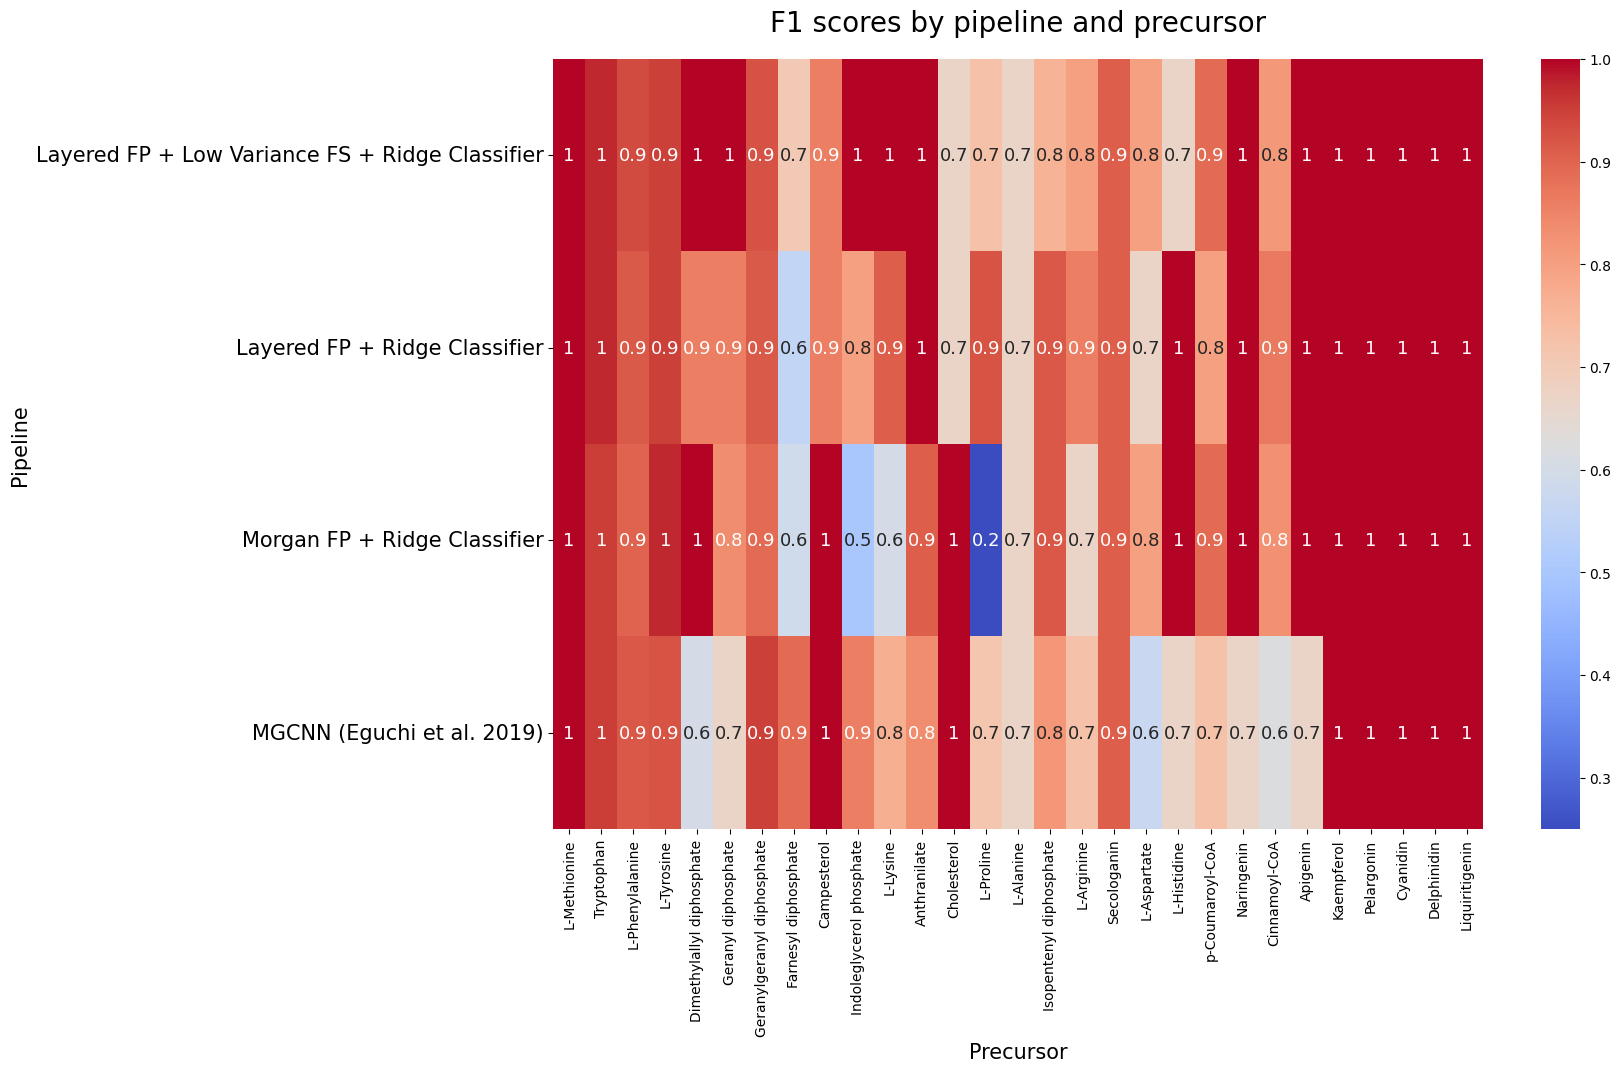

In [17]:
plt.figure(figsize=(15, 10))
sns.heatmap(df, annot=True, cmap='coolwarm', fmt='.1g', annot_kws={"size": 13})
plt.title('F1 scores by pipeline and precursor', pad=20, size=20)
plt.xlabel('Precursor', size=15)
plt.ylabel('Pipeline', size=15)
plt.yticks(size=15)
plt.savefig("f1_scores_by_pipeline_and_precursor.png")
plt.show()

In [18]:
# apply the wilcoxon test to all pairs of pipelines
import itertools
import scipy.stats as stats

f1_scores = [f1_scores_285, f1_scores_layered_fingerprints_baseline_ridge_classifier, f1_scores_morgan_fp, f1_scores_mgcnn]
pipeline_names = ["Layered FP + Low Variance FS + Ridge Classifier", "Layered FP + Ridge Classifier", "Morgan FP + Ridge Classifier", "MGCNN (Eguchi et al. 2019)"]

df = pd.DataFrame(f1_scores, columns=labels_names, index=pipeline_names)

significant_differences_f1 = []
for pipeline1, pipeline2 in itertools.combinations(pipeline_names, 2):
    p_value = stats.wilcoxon(df.loc[pipeline1, :], df.loc[pipeline2, :]).pvalue
    if p_value < 0.05:
        significant_differences_f1.append((pipeline1, pipeline2, "macro_f1_score", p_value))
                       

In [19]:
# apply the wilcoxon test to all pairs of pipelines
import itertools
import scipy.stats as stats

results_mgcnn = pd.read_csv("results_mgcnn.csv")
precision_mgcnn = results_mgcnn["precision"]

precision_scores = [precision_285, precision_layered_fingerprints_baseline_ridge_classifier, precision_morgan_fp, precision_mgcnn]
pipeline_names = ["Layered FP + Low Variance FS + Ridge Classifier", "Layered FP + Ridge Classifier", "Morgan FP + Ridge Classifier", "MGCNN (Eguchi et al. 2019)"]

df = pd.DataFrame(precision_scores, columns=labels_names, index=pipeline_names)

significant_differences_precision = []
for pipeline1, pipeline2 in itertools.combinations(pipeline_names, 2):
    p_value = stats.wilcoxon(df.loc[pipeline1, :], df.loc[pipeline2, :]).pvalue
    if p_value < 0.05:
        significant_differences_precision.append((pipeline1, pipeline2, "macro_precision_score", p_value))

/home/jcapela/miniforge3/envs/sm_precursor_predictor/lib/python3.10/site-packages/scipy/stats/_morestats.py:3159: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [20]:
# apply the wilcoxon test to all pairs of pipelines
import itertools
import scipy.stats as stats

results_mgcnn = pd.read_csv("results_mgcnn.csv")
recall_mgcnn = results_mgcnn["recall"]

recall_scores = [recall_285, recall_layered_fingerprints_baseline_ridge_classifier, recall_morgan_fp, recall_mgcnn] 
pipeline_names = ["Layered FP + Low Variance FS + Ridge Classifier", "Layered FP + Ridge Classifier", "Morgan FP + Ridge Classifier", "MGCNN (Eguchi et al. 2019)"]

df = pd.DataFrame(precision_scores, columns=labels_names, index=pipeline_names)

significant_differences_recall = []
for pipeline1, pipeline2 in itertools.combinations(pipeline_names, 2):
    p_value = stats.wilcoxon(df.loc[pipeline1, :], df.loc[pipeline2, :]).pvalue
    if p_value < 0.05:
        significant_differences_recall.append((pipeline1, pipeline2, "macro_precision_score", p_value))
    

/home/jcapela/miniforge3/envs/sm_precursor_predictor/lib/python3.10/site-packages/scipy/stats/_morestats.py:3159: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [21]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

In [22]:
for pipeline1, pipeline2, metric, pvalue in significant_differences_f1:
    print(f"{pipeline1} vs {pipeline2} for {metric}: p-value = {pvalue} {convert_pvalue_to_asterisks(pvalue)}")

Layered FP + Low Variance FS + Ridge Classifier vs MGCNN (Eguchi et al. 2019) for macro_f1_score: p-value = 0.03110019751085829 *
Layered FP + Ridge Classifier vs MGCNN (Eguchi et al. 2019) for macro_f1_score: p-value = 0.049210331648212605 *


In [23]:
for pipeline1, pipeline2, metric, pvalue in significant_differences_precision:
    print(f"{pipeline1} vs {pipeline2} for {metric}: p-value = {pvalue} {convert_pvalue_to_asterisks(pvalue)}")

Layered FP + Low Variance FS + Ridge Classifier vs Layered FP + Ridge Classifier for macro_precision_score: p-value = 0.003283460986069043 **
Layered FP + Low Variance FS + Ridge Classifier vs MGCNN (Eguchi et al. 2019) for macro_precision_score: p-value = 0.00197537701747741 **
Layered FP + Ridge Classifier vs Morgan FP + Ridge Classifier for macro_precision_score: p-value = 0.015551296117471627 *
Morgan FP + Ridge Classifier vs MGCNN (Eguchi et al. 2019) for macro_precision_score: p-value = 0.005191477473440576 **


In [24]:
for pipeline1, pipeline2, metric, pvalue in significant_differences_recall:
    print(f"{pipeline1} vs {pipeline2} for {metric}: p-value = {pvalue} {convert_pvalue_to_asterisks(pvalue)}")

Layered FP + Low Variance FS + Ridge Classifier vs Layered FP + Ridge Classifier for macro_precision_score: p-value = 0.003283460986069043 **
Layered FP + Low Variance FS + Ridge Classifier vs MGCNN (Eguchi et al. 2019) for macro_precision_score: p-value = 0.00197537701747741 **
Layered FP + Ridge Classifier vs Morgan FP + Ridge Classifier for macro_precision_score: p-value = 0.015551296117471627 *
Morgan FP + Ridge Classifier vs MGCNN (Eguchi et al. 2019) for macro_precision_score: p-value = 0.005191477473440576 **


In [25]:
# generate a table with significant differences
significant_differences = significant_differences_f1
# transform p-values to asterisks
significant_differences = [(pipeline1, pipeline2, convert_pvalue_to_asterisks(pvalue)) for pipeline1, pipeline2, metric, pvalue in significant_differences]

significant_differences_df = pd.DataFrame(significant_differences, columns=["Pipeline 1", "Pipeline 2", "Differences (F1 score)"])
significant_differences_df.to_csv("significant_differences.csv", index=False)

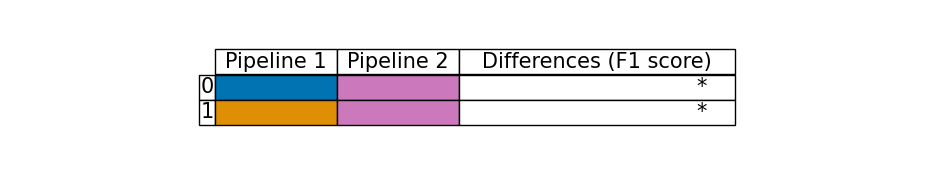

In [26]:
# save the table to a svg but still with the colors in the color_map
from pandas.plotting import table
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 2)) # set size frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
ax.set_frame_on(False)  # no visible frame
tabla = table(ax, significant_differences_df, loc='center', colWidths=[0.1, 0.1, 0.1])  # where df is your data frame
tabla.auto_set_font_size(False) # Activate set fontsize manually
tabla.set_fontsize(15) # if ++fontsize is necessary ++colWidths
tabla.scale(1.5, 1.5) # change size table
# hide the index
tabla.auto_set_column_width([0, 1, 2])

# apply the colors to the table
for i in range(len(significant_differences_df.columns)-1):
    for j, value in enumerate(significant_differences_df[significant_differences_df.columns[i]]):
        j+=1
        tabla[(j, i)].set_facecolor(color_map[value])
        tabla[(j, i)].set_text_props(text='')
        tabla[(j, i)].set_edgecolor('black')


plt.savefig('significant_differences.svg', transparent=True, dpi=400)
